<a href="https://colab.research.google.com/github/nhjung-phd/TimeSeriesAnalysis/blob/main/notebooks/00_data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

기본 시계열 데이터 전처리 (결측치 및 이상치 처리)

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

샘플 시계열 데이터 생성

In [41]:
np.random.seed(42)
dates = pd.date_range(start="2022-01-01", periods=100, freq="D")
values = np.random.randn(100).cumsum()  # 누적 합 형태의 시계열 데이터 생성
df = pd.DataFrame({"Date": dates, "Value": values})

결측치 삽입

In [42]:
df.loc[10:15, "Value"] = np.nan

결측치 처리 (선형 보간법 적용)

In [43]:
df["Value_Interpolated"] = df["Value"].interpolate(method="linear")

In [44]:
print(df["Value_Interpolated"].isna().sum())  # 0 이어야 정상

0


이상치 탐지 (IQR)

##IQR (Interquartile Range) with Box plots
데이터의 분포가 정규 분포를 이루지 않거나 한 쪽으로 skewed 한 경우, 데이터의 IQR 값을 이용해 이상치를 탐지하는 방법이다


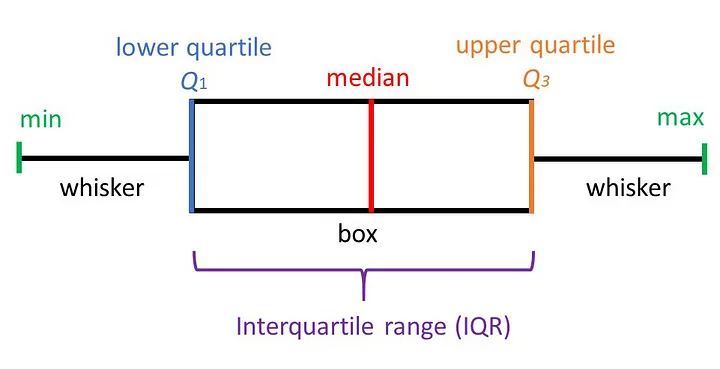

https://www.simplypsychology.org/boxplots.html
박스 플롯은 위와 같이 데이터의 최소값, 최대값, 중간값, 첫번째 사분위(Q1) 및 세번째 사분위(Q3) 값에 대한 정보를 제공한다.


여기서 사분위란, 말 그대로 데이터를 4등분 했을 때의 범위로 Q1 아래로는 최소값을 포함한 하위 25% 범위를, Q3 위로는 최대값을 포함한 상위 25% 범위를 포함한다. 이때 IQR 값은 Q3 에서 Q1 을 뺀 값이다.


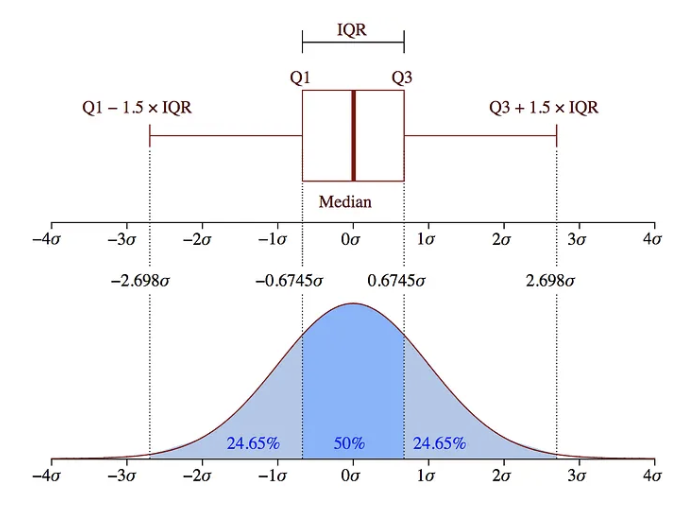

(Q1 – 1.5 * IQR) 보다 작거나 (Q3 + 1.5 * IQR) 보다 큰 데이터는 이상치로 처리한다. 1.5 보다 큰 3 혹은 그 이상의 값을 곱하기도 하며 값이 클수록 더욱 최극단의 이상치를 처리함을 알 수 있다.

In [45]:
Q1 = df["Value_Interpolated"].quantile(0.25)
Q3 = df["Value_Interpolated"].quantile(0.75)
IQR = Q3 - Q1
outliers = (df["Value_Interpolated"] < (Q1 - 1.5 * IQR)) | (df["Value_Interpolated"] > (Q3 + 1.5 * IQR))

아웃라이어 개수: 0 임계값: -18.578813972383628 4.651335072990482


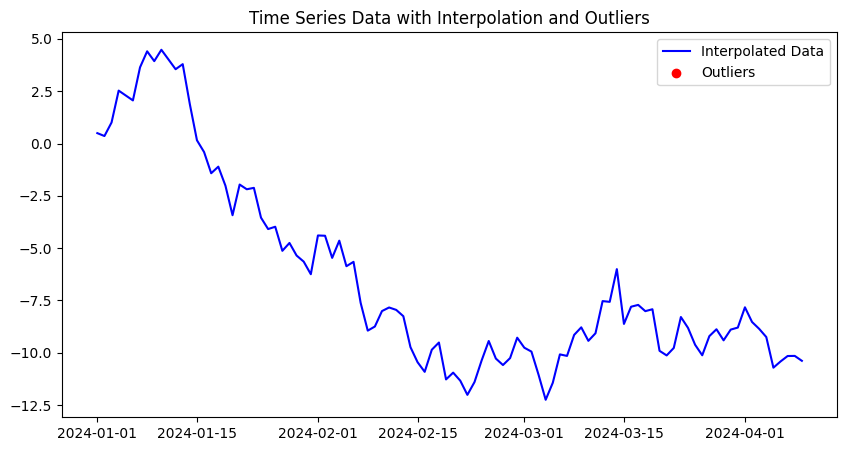

In [60]:
Q1 = df["Value_Interpolated"].quantile(0.25)
Q3 = df["Value_Interpolated"].quantile(0.75)
IQR = Q3 - Q1
k = 1.5  # 필요시 1.0으로 낮춰보세요
thr_low, thr_high = Q1 - k*IQR, Q3 + k*IQR
outliers = (df["Value_Interpolated"] < thr_low) | (df["Value_Interpolated"] > thr_high)
print("아웃라이어 개수:", outliers.sum(), "임계값:", thr_low, thr_high)

# 그래프출력
plt.figure(figsize=(10, 5))
plt.plot(df["Date"], df["Value_Interpolated"], label="Interpolated Data", color="blue")
plt.scatter(df["Date"][outliers], df["Value_Interpolated"][outliers], color="red", label="Outliers", zorder=3)
plt.title("Time Series Data with Interpolation and Outliers")
plt.legend()
plt.show()

### IQR 배수 줄이기 1.5 →  1.4 →  1.0

아웃라이어 개수: 2 임계값: -17.998060246249274 4.070581346856128


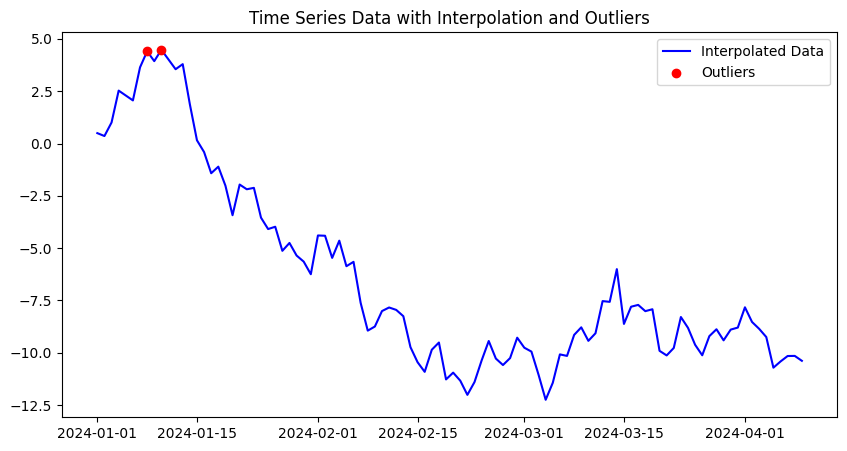

In [75]:
Q1 = df["Value_Interpolated"].quantile(0.25)
Q3 = df["Value_Interpolated"].quantile(0.75)
IQR = Q3 - Q1
k = 1.4  # 필요시 1.0으로 낮춰보세요
thr_low, thr_high = Q1 - k*IQR, Q3 + k*IQR
outliers = (df["Value_Interpolated"] < thr_low) | (df["Value_Interpolated"] > thr_high)
print("아웃라이어 개수:", outliers.sum(), "임계값:", thr_low, thr_high)

# 그래프출력
plt.figure(figsize=(10, 5))
plt.plot(df["Date"], df["Value_Interpolated"], label="Interpolated Data", color="blue")
plt.scatter(df["Date"][outliers], df["Value_Interpolated"][outliers], color="red", label="Outliers", zorder=3)
plt.title("Time Series Data with Interpolation and Outliers")
plt.legend()
plt.show()

In [76]:
import numpy as np, pandas as pd

# 1) 컬럼/타입/NA 점검
print("cols:", df.columns.tolist())
print("dtype:", df["Value_Interpolated"].dtype)
print("NA개수:", df["Value_Interpolated"].isna().sum())

# 2) 값 범위 & 임계값
Q1 = df["Value_Interpolated"].quantile(0.25)
Q3 = df["Value_Interpolated"].quantile(0.75)
IQR = Q3 - Q1
k = 1.5
thr_low, thr_high = Q1 - k*IQR, Q3 + k*IQR
print("min/max:", df["Value_Interpolated"].min(), df["Value_Interpolated"].max())
print("IQR 임계:", thr_low, thr_high)

# 3) 마스크/인덱스 정렬(중요)
df = df.sort_values("Date").reset_index(drop=True)
mask = (df["Value_Interpolated"] < thr_low) | (df["Value_Interpolated"] > thr_high)
print("mask dtype:", mask.dtype, "mask True 수:", mask.sum())
print("mask NA 수:", mask.isna().sum())


cols: ['Date', 'Value', 'Value_Interpolated']
dtype: float64
NA개수: 0
min/max: -12.246655796825202 4.4806111169875615
IQR 임계: -18.578813972383628 4.651335072990482
mask dtype: bool mask True 수: 0
mask NA 수: 0


### 분위수 컷(상하위 1%)

분위수 컷 이상치 수: 2


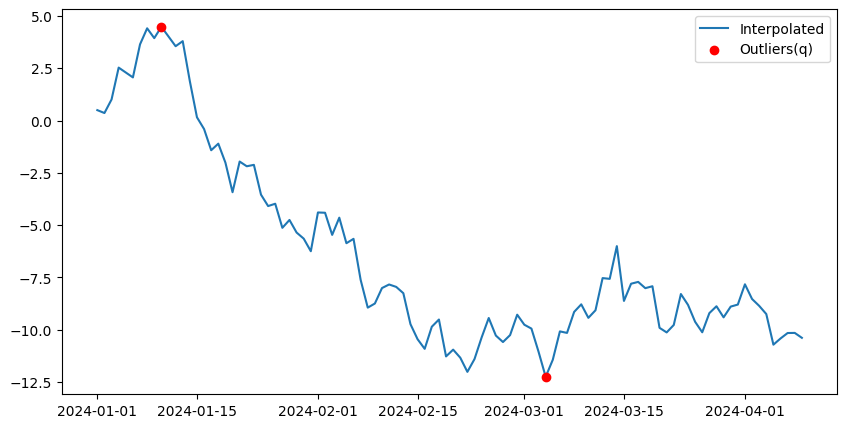

In [78]:
x = df["Value_Interpolated"]
low, high = x.quantile(0.01), x.quantile(0.99)   # 1% 꼬리
mask_q = (x < low) | (x > high)
print("분위수 컷 이상치 수:", mask_q.sum())

# 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(df["Date"], x, label="Interpolated")
plt.scatter(df.loc[mask_q, "Date"], x[mask_q], color ='red',label="Outliers(q)", zorder=5)
plt.legend(); plt.show()
